# Examples

## setup

Must install h5coro to have it accessible as an engine.

Must use pip **not** conda. conda h5coro is v0.0.6, which does not have the funcionality to be located by xarray as a backend. pip h5coro is v0.0.8, which does.

In [1]:
%pip install -q "xarray>=2025.8.0" 
%pip install -q "h5coro==0.0.8"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmip 0.7.2 requires cf_xarray>=0.6.0, which is not installed.
xmip 0.7.2 requires xarrayutils, which is not installed.
xmip 0.7.2 requires xgcm<0.7.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [101]:
%load_ext autoreload
%autoreload 2

%matplotlib widget
import xarray as xr
import earthaccess
import os
import h5coro
from rasterio.session import AWSSession
import boto3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
h5coro.__version__

'0.0.8'

## Authenticating

In [102]:
s3url_atl06 = 'nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2019/12/02/ATL06_20191202203649_10220511_006_01.h5'
auth = earthaccess.login()
creds = auth.get_s3_credentials(daac='NSIDC')

In [103]:
# Authenticate for accessing NASA data
auth = earthaccess.login(strategy="interactive")

In [104]:
results = earthaccess.search_data(
    short_name='ATL06',
    cloud_hosted=True,
    bounding_box=(-45.4, 62.63, -44.6, 63.0),   
    granule_name="ATL06_*_????25??_*_*.h5",
)

if not results:
    raise RuntimeError("No granules found with this query.")

# # OpenFile-like handles that xarray can use
# opened = list(earthaccess.open(results))  # make it indexable
K = len(results)
print(f"Found {K} granules.")

Found 9 granules.


In [28]:
# # Authenticate for boto S3 access, etc.
# os.environ["AWS_REQUEST_PAYER"] = "requester"
# aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [40]:
# # Setup and authenticate 
# from dask.distributed import Client
# import logging
# client = Client(processes=True, n_workers=4, 
#                 threads_per_worker=1,
#                 silence_logs=logging.ERROR)
# client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
# client

## Data Access -- Cloud

In [45]:
%%timeit -r 5

ds = xr.open_dataset(s3url_atl06, engine='h5coro', group='/gt2l/land_ice_segments', credentials=creds)
ds.h_li.load()
ds.latitude.load()
ds.longitude.load()
ds.delta_time.load()

1.47 s ± 237 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [ ]:
ds.nbytes / 1e6

### Data Access -- Local

Need to use verion 1.0.0 of h5coro in order for the https reader to be available to the h5coro xarray engine

In [2]:
https = 'https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2019/12/02/ATL06_20191202203649_10220511_006_01.h5'

In [ ]:
%%timeit -r 5

ds = xr.open_dataset(https, engine='h5coro', group='/gt2l/land_ice_segments')
ds.h_li.load()
ds.latitude.load()
ds.longitude.load()
ds.delta_time.load()

# Multi granule test via CryoCloud

## No fsspec adjustments to open_dataset+concat and mfdataset

In [ ]:
import os, time, math, warnings
import numpy as np
import xarray as xr
import earthaccess
import matplotlib.pyplot as plt

ENGINE = "h5netcdf"   # engine for HDF5/NetCDF (try "h5netcdf" first; "h5py" also possible)
GROUP  = "/gt2l/land_ice_segments"                 # beam/group to test
VARS   = ["h_li", "latitude", "longitude", "delta_time"]  # vars to load
CONCAT_DIM = "file"                                # concat dimension

def time_open_individual(results):
    """Open each file separately (no concat)."""
    t0 = time.perf_counter()
    dsets = []
    urls = list(earthaccess.open(results))
    for u in urls:
        ds = xr.open_dataset(u, group=GROUP, engine=ENGINE)
        dsets.append(ds)
    t1 = time.perf_counter()
    # Close immediately to avoid holding many file handles
    for ds in dsets:
        ds.close()
    return t1 - t0

ENGINE = "h5netcdf"  # or "h5py"

def time_open_and_concat(results, dim_name="file"):
    import time
    t0 = time.perf_counter()
    dsets = []
    urls = list(earthaccess.open(results))
    try:
        for i, u in enumerate(urls):
            ds = xr.open_dataset(u,  group=GROUP, engine=ENGINE)

            #***Do I need this??
            dname = dim_name if dim_name not in ds.dims and dim_name not in ds.coords and dim_name not in ds.variables else f"{dim_name}_bench"
            ds = ds.expand_dims({dname: [i]})
            dsets.append(ds)

        ds_all = xr.concat(
            dsets,
            dim=dname,
            join="outer",
        )
    finally:
        for ds in dsets:
            ds.close()
        if "ds_all" in locals():
            ds_all.close()

    return time.perf_counter() - t0


def time_open_mf(results, dim_name="file"):
    import time, warnings, math
    t0 = time.perf_counter()
    urls = list(earthaccess.open(results))
    try:
        ds = xr.open_mfdataset(
            urls,
            group=GROUP,
            engine=ENGINE,
            combine="nested",
            concat_dim=dim_name,
            parallel=True,
            join="outer",
            credentials=creds
        )
        ds.close()
        return time.perf_counter() - t0
    except Exception as e:
        warnings.warn(f"open_mfdataset failed for N={len(urls)}: {e}")
        return math.nan



# ---- Run benchmarks as N grows ----
Ns = list(range(1, K + 1))
times_individual0 = []
times_concat0 = []
times_mf0 = []

for n in tqdm(Ns, desc="Processing"):
    results_n = results[:n]
    times_individual0.append(time_open_individual(results_n))
    times_concat0.append(time_open_and_concat(results_n))
    times_mf0.append(time_open_mf(results_n))

In [ ]:
%%time
urls = list(earthaccess.open(results_n[0:2]))
ds = xr.open_mfdataset(
    ds = xr.open_mfdataset( urls, engine=ENGINE, group=GROUP, combine="nested", concat_dim=concat_dim, parallel=True, data_vars="minimal", coords="minimal", compat="override", join="outer", combine_attrs="drop", credentials=creds )
)
ds.close()

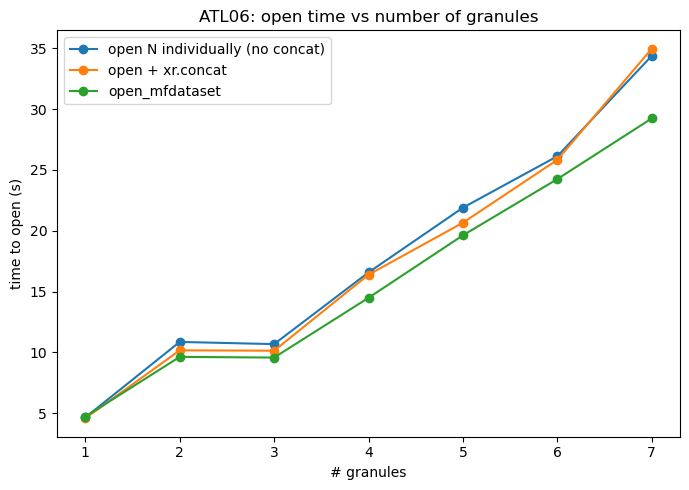

In [21]:
# ---- Plot results ----
Nss = Ns[:7]
plt.figure(figsize=(7,5))
plt.plot(Nss, times_individual0[:-1], marker="o", label="open N individually (no concat)")
plt.plot(Nss, times_concat0,    marker="o", label="open + xr.concat")
plt.plot(Nss, times_mf0,        marker="o", label="open_mfdataset")
plt.xlabel("# granules")
plt.ylabel("time to open (s)")
plt.title("ATL06: open time vs number of granules")
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
# Optional: print a small table
import pandas as pd
summary = pd.DataFrame({
    "N": Nss,
    "open_individual_s": times_individual0[:-1],
    "open_plus_concat_s": times_concat0,
    "open_mfdataset_s": times_mf0,
})
print(summary.to_string(index=False))

NameError: name 'Nss' is not defined

In [108]:
import pandas as pd
import pandas as pd

summary0 = pd.DataFrame(
    {
        "N": [1, 2, 3, 4, 5, 6, 7],
        "open_individual_s": [4.666239, 10.869376, 10.688597, 16.577995, 21.896558, 26.122656, 34.368302],
        "open_plus_concat_s": [4.597454, 10.176074, 10.147878, 16.391922, 20.660627, 25.826465, 34.951432],
        "open_mfdataset_s": [4.727618, 9.640833, 9.583287, 14.491854, 19.626191, 24.246337, 29.229270],
    }
).astype(
    {
        "N": "int64",
        "open_individual_s": "float64",
        "open_plus_concat_s": "float64",
        "open_mfdataset_s": "float64",
    }
).set_index("N")
summary0

,open_individual_s,open_plus_concat_s,open_mfdataset_s
N,,,
1,4.666239,4.597454,4.727618
2,10.869376,10.176074,9.640833
3,10.688597,10.147878,9.583287
4,16.577995,16.391922,14.491854
5,21.896558,20.660627,19.626191
6,26.122656,25.826465,24.246337
7,34.368302,34.951432,29.229270


## H5coro as an engine in xarray

In [33]:
# os.environ["AWS_ACCESS_KEY_ID"] = creds["accessKeyId"]
# os.environ["AWS_SECRET_ACCESS_KEY"] = creds["secretAccessKey"]
# os.environ["AWS_SESSION_TOKEN"] = creds["sessionToken"]
# os.environ["AWS_REQUEST_PAYER"] = "requester" 

In [48]:
import os, re, time, math, warnings
import earthaccess as ea
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# --------------------------
# Config
# --------------------------
ENGINE = "h5coro"                                  # xarray backend
GROUP  = "/gt2l/land_ice_segments"                 # beam/group to test
VARS   = ["h_li", "latitude", "longitude", "delta_time"]  # vars to load
CONCAT_DIM = "file"                                # concat dimension
BBOX = (-45.4, 62.63, -44.6, 63.0)                 # your bbox
GLOB = "ATL06_*_????25??_*_*.h5"                   # your granule glob


# --------------------------
# Convert HTTPS links -> h5coro bucket/key form
# https://data.nsidc.earthdatacloud.nasa.gov/<bucket>/... -> <bucket>/...
# --------------------------
def to_h5coro_path(url: str) -> str:
    return re.sub(r"^https://data\.nsidc\.earthdatacloud\.nasa\.gov/", "", url)

urls = []
for g in results:
    for u in g.data_links():
        if u.endswith(".h5"):
            urls.append(to_h5coro_path(u))

if not urls:
    raise RuntimeError("No HTTPS .h5 links found; cannot build h5coro paths.")

K = len(urls)
print(f"Found {K} ATL06 granules (h5coro paths). Example:\n  {urls[0]}")

# --------------------------
# Helpers
# --------------------------
def open_and_load(url):
    """Open one file via h5coro, select present VARS, force-load them."""
    ds = xr.open_dataset(url, engine=ENGINE, group=GROUP,credentials=creds)
    present = [v for v in VARS if v in ds.variables]
    if not present:
        # fall back to the first numeric variable to trigger I/O
        for vname, var in ds.variables.items():
            if np.issubdtype(var.dtype, np.number):
                present = [vname]
                break
    sub = ds[present] if present else ds
    _ = [sub[v].load() for v in sub.variables]  # force I/O
    return ds, sub

def time_open_individual(url_list):
    t0 = time.perf_counter()
    dsets = []
    try:
        for u in url_list:
            ds, _ = open_and_load(u)
            dsets.append(ds)
    finally:
        for ds in dsets:
            ds.close()
    return time.perf_counter() - t0

def time_open_and_concat(url_list, concat_dim=CONCAT_DIM):
    t0 = time.perf_counter()
    parts, dsets = [], []
    try:
        for i, u in enumerate(url_list):
            ds, sub = open_and_load(u)
            dsets.append(ds)
            name = concat_dim
            if name in sub.dims or name in sub.coords or name in sub.variables:
                name = f"{concat_dim}_bench"
            parts.append(sub.expand_dims({name: [i]}))

        combined = xr.concat(
            parts,
            dim=name,
            # data_vars="minimal",
            # coords="minimal",     # <-- avoid coords='different' conflict
            # compat="override",
            join="outer",
            # combine_attrs="drop",
        )
        # Nudge materialization a bit (coords/attrs)
        _ = list(combined.coords)
    finally:
        for ds in dsets:
            ds.close()
        if "combined" in locals():
            combined.close()
    return time.perf_counter() - t0

def time_open_mf(url_list, concat_dim=CONCAT_DIM):
    t0 = time.perf_counter()
    if len(url_list)>1:
        try:
            ds = xr.open_mfdataset(
                url_list,
                engine=ENGINE,
                group=GROUP,
                combine="nested",
                # concat_dim=concat_dim,
                parallel=True,
                # data_vars="minimal",
                # coords="minimal",
                # compat="override",
                join="outer",
                # combine_attrs="drop",
                credentials=creds
            )
            # present = [v for v in VARS if v in ds.variables]
            # present = present or list(ds.variables)[:1]
            # _ = [ds[v].load() for v in present]  # force I/O
            ds.close()
            return time.perf_counter() - t0
        except Exception as e:
            warnings.warn(f"open_mfdataset failed for N={len(url_list)}: {e}")
            return math.nan

# --------------------------
# Run the benchmarks
# --------------------------
Ns = list(range(1, K + 1))
times_individualHC = []
times_concatHC = []
times_mfHC = []

for n in tqdm(Ns, desc="Processing"):
    sub = urls[:n]
    times_individualHC.append(time_open_individual(sub))
    times_concatHC.append(time_open_and_concat(sub))
    # times_mfHC.append(time_open_mf(sub))

# ---- Run benchmarks as N grows ----
Ns = list(range(1, K + 1))
times_individual0 = []
times_concat0 = []
times_mf0 = []

for n in tqdm(Ns, desc="Processing"):
    results_n = results[:n]
    times_individualHC.append(time_open_individual(results_n))
    times_concatHC.append(time_open_and_concat(results_n))
    times_mfHC.append(time_open_mf(results_n))

Found 9 ATL06 granules (h5coro paths). Example:
  nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2024/09/22/ATL06_20240922103833_00942503_006_01.h5


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
ds = xr.open_mfdataset(
                suburls,
                engine=ENGINE,
                group=GROUP,
                combine="nested",
                # concat_dim=concat_dim,
                parallel=True,
                # data_vars="minimal",
                # coords="minimal",
                # compat="override",
                join="outer",
                # combine_attrs="drop",
                credentials=creds
            )

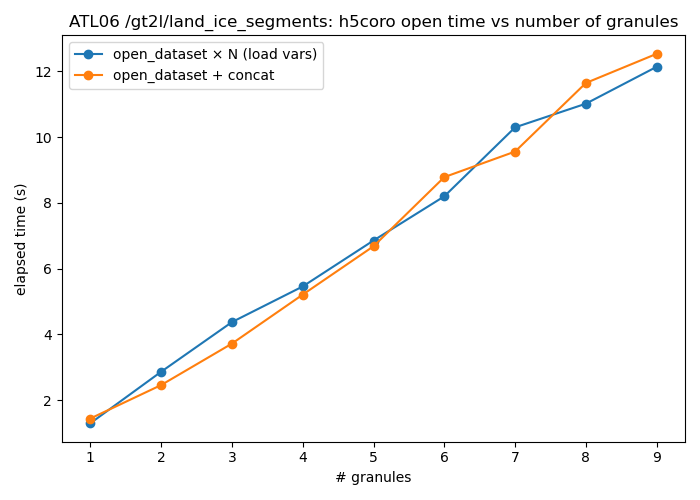

In [51]:
# --------------------------
# Plot + table
# --------------------------
plt.figure(figsize=(7,5))
plt.plot(Ns, times_individualHC, marker="o", label="open_dataset × N (load vars)")
plt.plot(Ns, times_concatHC,    marker="o", label="open_dataset + concat")
# plt.plot(Ns, times_mfHC,        marker="o", label="open_mfdataset (nested)")
plt.xlabel("# granules")
plt.ylabel("elapsed time (s)")
plt.title(f"ATL06 {GROUP}: h5coro open time vs number of granules")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
summary = pd.DataFrame({
    "N": Ns,
    "open_dataset_each_s": times_individual,
    "open_plus_concat_s":  times_concat,
    # "open_mfdataset_s":    times_mf,
})
print(summary.to_string(index=False))

In [53]:
import pandas as pd

summaryh5 = pd.DataFrame(
    {
        "N": [1, 2, 3, 4, 5, 6, 7, 8, 9],
        "open_dataset_each_s": [1.264234, 2.701511, 3.455585, 5.423653, 6.110192, 7.494952, 8.792239, 9.749951, 11.564362],
        "open_plus_concat_s":  [0.972788, 2.893569, 3.431660, 4.777823, 6.364322, 13.079246, 13.480917, 10.134341, 11.437841],
    }
).astype(
    {
        "N": "int64",
        "open_dataset_each_s": "float64",
        "open_plus_concat_s": "float64",
    }
).set_index("N")

# Using fsspec

In [60]:
fsspec_kwargs = {
    "cache_type": "blockcache", 
    "block_size": 8*1024*1024
}

h5py_kwargs = {
    # "page_buf_size": 16*1024*1024,
    "rdcc_nbytes": 4*1024*1024
}

In [83]:
# pip installs if needed:
# !pip install s3fs earthaccess xarray h5netcdf pandas

import re, time, warnings
import pandas as pd
import numpy as np
import xarray as xr
import s3fs

# --------------------------
# Config
# --------------------------
ENGINE = "h5netcdf"
GROUP = "/gt2l/land_ice_segments"
VARS = ["h_li", "latitude", "longitude", "delta_time"]
CONCAT_DIM = "file"
MAX_N = 10  # test 1..10 granules

# --------------------------
# Build s3:// URLs from earthaccess results (HTTPS -> s3)
# --------------------------
# def https_to_s3(u: str) -> str:
#     # https://data.nsidc.earthdatacloud.nasa.gov/<bucket>/... -> s3://<bucket>/...
#     return re.sub(r"^https://data\.nsidc\.earthdatacloud\.nasa\.gov/([^/]+)/", r"s3://\1/", u)

# urls = []
# for g in results:
#     for u in g.data_links(access="direct"):
#         if u.endswith(".h5"):
#             urls.append(https_to_s3(u))

# if not urls:
#     raise RuntimeError("No ATL06 .h5 links found in results.")

# urls = urls[:MAX_N]  # cap to 10 if more are found

# --------------------------
# Authenticated S3 filesystem (Requester Pays)
# --------------------------
creds = earthaccess.get_s3_credentials("NSIDC")
s3 = s3fs.S3FileSystem(
    anon=False,
    key=creds["accessKeyId"],
    secret=creds["secretAccessKey"],
    token=creds["sessionToken"],
    requester_pays=True,
)
fsspec_kwargs = {}  # your pattern includes this; FS already holds creds

# --------------------------
# Open-one helper (your exact method)
# --------------------------
def open_one_subset(url: str) -> xr.Dataset:
    with s3.open(url, "rb", **fsspec_kwargs) as fo:
        ds = xr.open_dataset(
            fo,
            engine=ENGINE,
            group=GROUP,
            driver_kwds={"rdcc_nbytes": 1024 * 1024},  # as requested
        )
        ds.close()
    return sub

# --------------------------
# Test A: open-a-file-then-concat
# --------------------------
def time_open_then_concat(url_list, concat_dim=CONCAT_DIM):
    t0 = time.perf_counter()
    parts = []
    name = concat_dim
    for i, u in enumerate(url_list):
        sub = open_one_subset(u)
        parts.append(sub.expand_dims({name: [i]}))
    combined = xr.concat(
        parts,
        dim=name,
        join="outer",
    )
    combined.close()
    return time.perf_counter() - t0

# # --------------------------
# # Test B: open_mfdataset using file objects
# # --------------------------
# def time_open_mfdataset(url_list, concat_dim=CONCAT_DIM):
#     t0 = time.perf_counter()
#     try:
#         files = s3.open_files(url_list, mode="rb", **fsspec_kwargs)
#         ds = xr.open_mfdataset(
#             files,
#             engine=ENGINE,
#             group=GROUP,
#             combine="nested",
#             concat_dim=concat_dim,
#             data_vars="minimal",
#             coords="minimal",
#             compat="override",
#             join="outer",
#             combine_attrs="drop",
#             parallel=False,  # safer for auth & file-objects
#         )
#         try:
#             present = [v for v in VARS if v in ds.variables] or [next(iter(ds.variables))]
#             _ = [ds[v].load() for v in present]  # force I/O
#         finally:
#             ds.close()
#         return time.perf_counter() - t0
#     except Exception as e:
#         warnings.warn(f"open_mfdataset failed for N={len(url_list)}: {e}")
#         return np.nan

# --------------------------
# Run the 1..10 granule tests
# --------------------------
Ns = list(range(1, K + 1))
times_concatFS = []
times_mfFS = []

for n in tqdm(Ns, desc="Processing"):
    suburls = urls[:n]
    times_concatFS.append(time_open_then_concat(suburls))
    # times_mfFS.append(time_open_mfdataset(suburls))


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

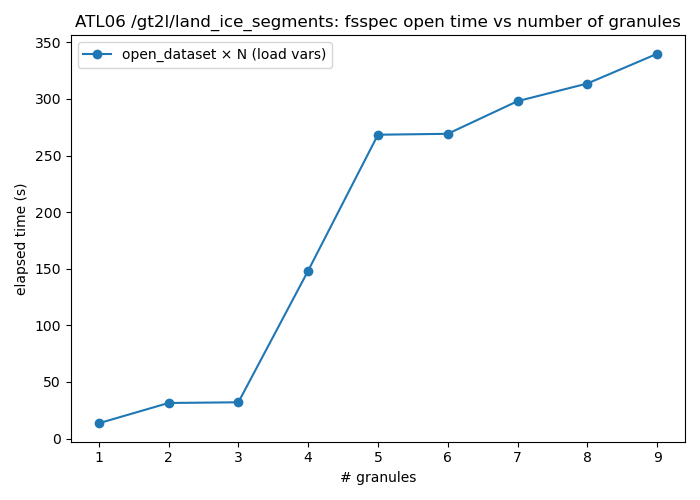

In [84]:
plt.figure(figsize=(7,5))
plt.plot(Ns, times_concatFS, marker="o", label="open_dataset × N (load vars)")
# plt.plot(Ns, times_mfFS,    marker="o", label="open_dataset + concat")
plt.xlabel("# granules")
plt.ylabel("elapsed time (s)")
plt.title(f"ATL06 {GROUP}: fsspec open time vs number of granules")
plt.legend()
plt.tight_layout()
plt.show()

In [109]:
summaryFS = pd.DataFrame(
    {"N": Ns, "open_plus_concat_s": times_concatFS}#, "open_mfdataset_s": times_mfFS}
).set_index("N")

print(summaryFS)

   open_plus_concat_s
N                    
1           13.525144
2           31.429949
3           32.037139
4          148.284063
5          268.377748
6          269.177276
7          298.008845
8          313.591369
9          339.846387


# All together

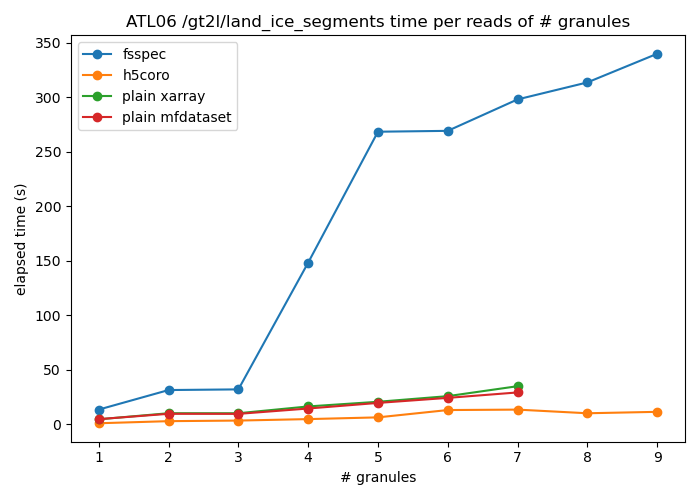

In [110]:
plt.figure(figsize=(7,5))
# plt.plot(Ns, times_concatFS, marker="o", label="fsspec")
plt.plot(Ns, summaryFS.open_plus_concat_s, marker="o", label="fsspec")
# plt.plot(Ns, times_concatHC, marker="o", label="h5coro")
plt.plot(Ns, summaryh5.open_plus_concat_s, marker="o", label="h5coro")
plt.plot(summary0.index, summary0.open_plus_concat_s, marker="o", label="plain xarray")
plt.plot(summary0.index, summary0.open_mfdataset_s, marker="o", label="plain mfdataset")
plt.xlabel("# granules")
plt.ylabel("elapsed time (s)")
plt.title(f"ATL06 {GROUP} time per reads of # granules")
plt.legend()
plt.tight_layout()
plt.show()